In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

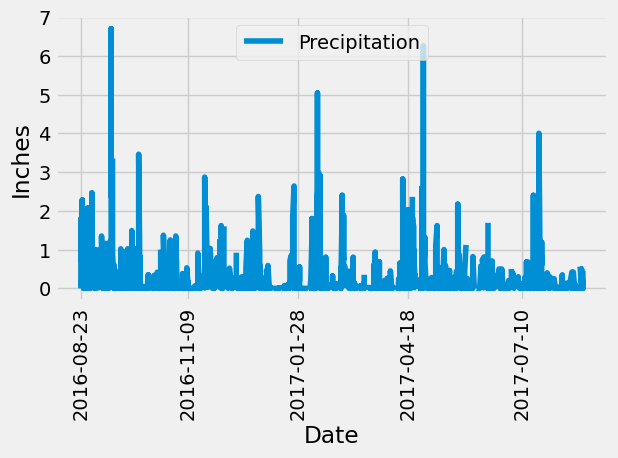

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10'], rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = pd.DataFrame(df['Precipitation'].describe())
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
output = [(total_stations,)]
output

[(9,)]

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

most_active_stations_formatted = [(station, count) for station, count in most_active_stations]
most_active_stations_formatted


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

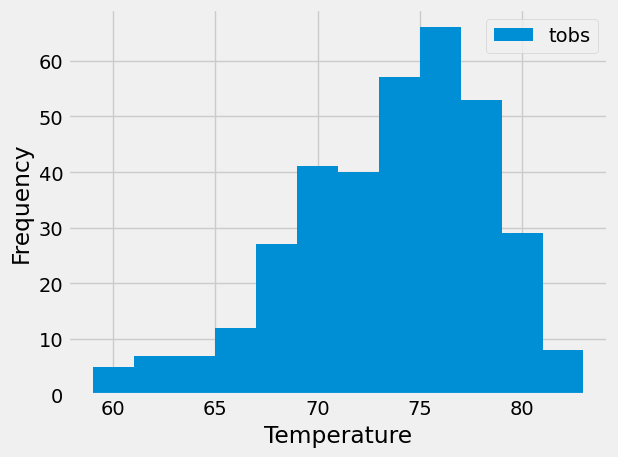

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query the temperature observations for the most active station within the last 12 months
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago).all()

# Save the query results into a Pandas DataFrame
df_temperature = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram
plt.hist(df_temperature['Temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks([60, 65, 70, 75, 80])
plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.legend(['tobs'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [42]:
# Close Session
session.close()